### Guo et al (Kmodels)

Test for 1 feat continuous GFS test

kmodels 完成，用时 0:00:05.319051, 迭代 58 次
split_components 完成，用时 0:00:05.331043
greedy_merge 完成，用时 0:00:14.298652, 合并 2031 次
最终 SSR = 389.1235


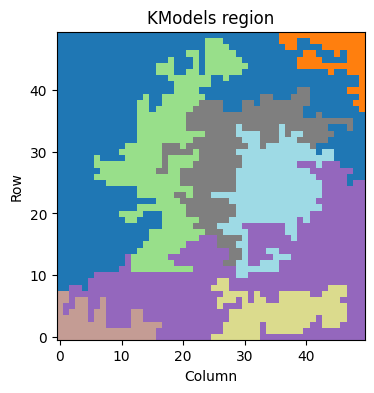

In [45]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from libpysal import weights
from Algorithm9 import kmodels, split_components, greedy_merge
from Network9 import Test_Equations, regression_error
from GridData9 import *

def Pos_Encode(r,c,side):
    return r*side+c

def Pos_Decode(code,side):
    return code//side, code%side

df = pd.read_csv('D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data/Continuous_data_1_coef.txt', sep='\t')

# 这里只用feat1作为自变量
X = df[['feat1']].to_numpy()
y = df['y'].to_numpy()

Xs = preprocessing.StandardScaler().fit_transform(X)
ys = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1)).ravel()

# 添加常数项
Xarr = np.hstack([np.ones((Xs.shape[0],1)), Xs])  # shape = (N, p+1)
Yarr = ys  # shape = (N,)

#空间权重矩阵
#利用网格坐标 u, v 生成 lat2W
N = df.shape[0]
# 假设 u, v 从 0 到 side-1 网格索引
side = int(np.sqrt(N))
w = weights.lat2W(side, side).symmetrize()

n_regions = 8        # 目标区域数
Kfac = 2                                  # 扩大因子，可调
micro_clusters = Kfac * n_regions         # 微簇数
min_region = 20                           # 最小区域规模

# KModels
start_time = datetime.datetime.now()
clabel, iters = kmodels(
    Xarr, Yarr,
    micro_clusters,
    w,
    init_stoc_step=False,
    verbose=False
)

rlabel, rcoeff, merges = greedy_merge(
    Xarr, Yarr,
    n_regions,
    w,
    slabel,
    min_size=min_region,
    verbose=False
)


units = np.arange(N)
regions = [units[rlabel == k].tolist() for k in sorted(set(rlabel))]
ssr = regression_error(regions, Xarr, Yarr)
print(f"最终 SSR = {ssr:.4f}")

# 统计检验
"""
with open('kmodels_results.txt', 'w') as log:
    log.write(f"运行时间: {datetime.datetime.now().ctime()}\n")
    log.write(f"目标区域数: {n_regions}, 微簇数: {micro_clusters}\n")
    log.write(f"SSR: {ssr:.4f}, 迭代: {iters}, 合并: {merges}\n\n")
    # 写系数
    for idx, coeff in enumerate(rcoeff):
        log.write(f"区域 {idx} 系数: " + " ".join(f"{c:.4f}" for c in coeff) + "\n")
    log.write("\n统计检验:\n")
    Test_Equations(regions, Xarr, Yarr, log)
"""

grid = reg_pic(side, rlabel)
plt.figure(figsize=(6,4))
plt.imshow(grid, origin='lower', cmap='tab20')
#plt.colorbar(label='ID')
plt.title('KModels region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


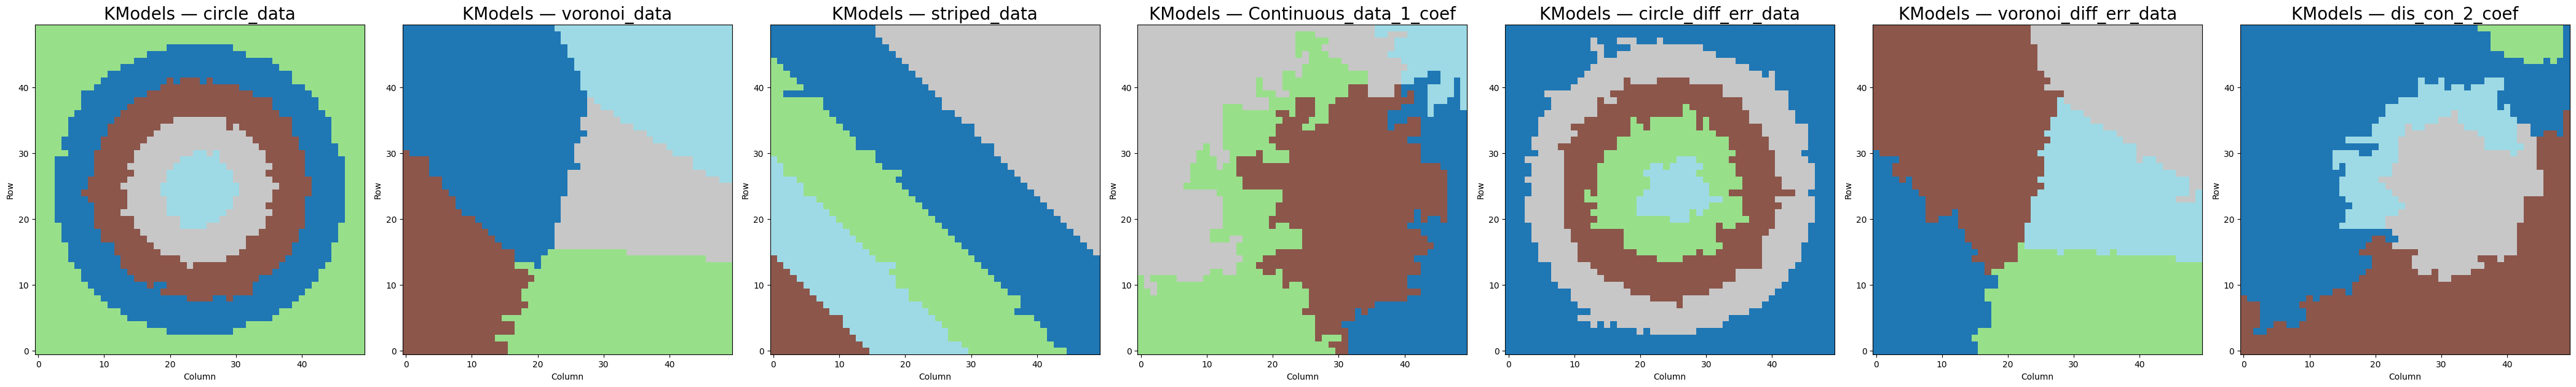

In [37]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from libpysal import weights
from Algorithm9 import kmodels, split_components, greedy_merge
from Network9 import regression_error
from GridData9 import reg_pic

data_dir   = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = ["circle_data.txt", 
              "voronoi_data.txt", 
              "striped_data.txt",
              "Continuous_data_1_coef.txt",
              "circle_diff_err_data.txt",
              "voronoi_diff_err_data.txt",
             "dis_con_2_coef.txt"]

grids, titles = [], []
for fname in file_names:
    df = pd.read_csv(os.path.join(data_dir, fname), sep='\t')
    feat_cols = [c for c in df.columns if c.startswith('feat')]
    X = df[feat_cols].to_numpy()  
    y  = df['y'].to_numpy()
    Xs   = preprocessing.StandardScaler().fit_transform(X)
    ys   = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1)).ravel()
    Xarr = np.hstack([np.ones((len(y),1)), Xs])
    Yarr = ys
    
    N    = len(df)
    side = int(np.sqrt(N))
    w    = weights.lat2W(side, side).symmetrize()
    
    n_regions      = 5
    micro_clusters = 2 * n_regions
    min_region     = 20
    # KModels
    clabel, _      = kmodels(Xarr, Yarr, micro_clusters, w, init_stoc_step=False, verbose=False)
    slabel         = split_components(w, clabel)
    rlabel, _, _   = greedy_merge(Xarr, Yarr, n_regions, w, slabel, min_size=min_region, verbose=False)

    grids.append(reg_pic(side, rlabel)) # grid形式保存
    titles.append(fname[:-4])  # 去掉 .txt当标题

fig, axes = plt.subplots(1, len(grids), figsize=(6*len(grids), 6), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    im = ax.imshow(grid, origin='lower', cmap='tab20')
    ax.set_title(f"KModels — {title}", fontsize=20)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

plt.tight_layout()
plt.show()

In [42]:
data_dir_2   = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names_2 = ["dis_con_2_coef.txt"]

grids, titles = [], []
for fname in file_names_2:
    df = pd.read_csv(os.path.join(data_dir_2, fname), sep='\t')
    feat_cols = [c for c in df.columns if c.startswith('feat')]
    X = df[feat_cols].to_numpy()  
    y  = df['y'].to_numpy()
    Xs   = preprocessing.StandardScaler().fit_transform(X)
    ys   = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1)).ravel()
    Xarr = np.hstack([np.ones((len(y),1)), Xs])
    Yarr = ys

    N    = len(df)
    side = int(np.sqrt(N))
    w    = weights.lat2W(side, side).symmetrize()

    n_regions      = 8
    micro_clusters = 2 * n_regions
    min_region     = 20
    # KModels
    clabel, _      = kmodels(Xarr, Yarr, micro_clusters, w, init_stoc_step=False, verbose=False)
    slabel         = split_components(w, clabel)
    rlabel, _, _   = greedy_merge(Xarr, Yarr, n_regions, w, slabel, min_size=min_region, verbose=False)

    grids.append(reg_pic(side, rlabel))
    titles.append(fname[:-4])

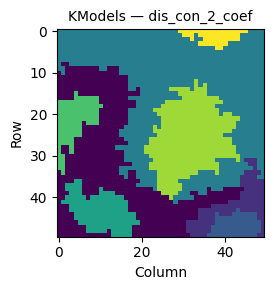

In [44]:
# 2) plot
fig, axes = plt.subplots(1, len(grids), figsize=(3, 3), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    im = ax.imshow(grid, cmap='viridis')
    ax.set_title(f"KModels — {title}", fontsize=10)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

plt.tight_layout()
plt.show()

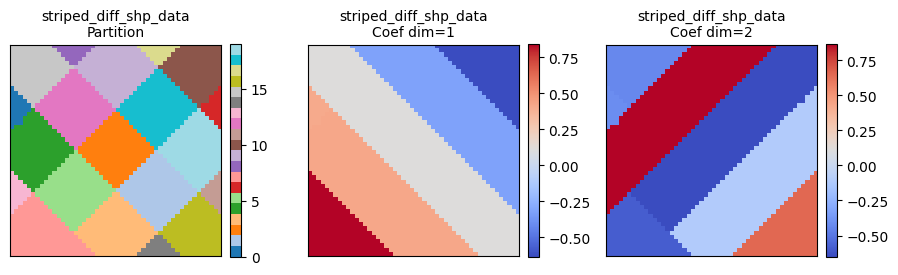

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from libpysal import weights
from Algorithm9 import kmodels, split_components, greedy_merge
from GridData9 import reg_pic

# ——— 修改这里 ———
data_dir   = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = [
    "striped_diff_shp_data.txt", 
]
n_regions      = 20
micro_clusters = 2 * n_regions
min_region     = 20
# 想画的系数维度（1→feat1, 2→feat2）
dims = [1, 2]
# —————————

titles = [fn[:-4] for fn in file_names]

# 1) 收集所有要画的 “(grid, subtitle)” 对
to_plot = []
for title, fname in zip(titles, file_names):
    # 读取并预处理
    df = pd.read_csv(os.path.join(data_dir, fname), sep='\t')
    feat_cols = [c for c in df.columns if c.startswith('feat')]
    X = df[feat_cols].to_numpy()
    y = df['y'].to_numpy()
    Xs = preprocessing.StandardScaler().fit_transform(X)
    ys = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1)).ravel()
    Xarr = np.hstack([np.ones((len(y),1)), Xs])
    Yarr = ys

    # 空间邻接
    N    = len(df)
    side = int(np.sqrt(N))
    w    = weights.lat2W(side, side).symmetrize()

    # KModels → split → merge
    clabel, _        = kmodels(Xarr, Yarr, micro_clusters, w,
                               init_stoc_step=False, verbose=False)
    slabel           = split_components(w, clabel)
    rlabel, rcoeff, _= greedy_merge(
                          Xarr, Yarr, n_regions, w, slabel,
                          min_size=min_region, verbose=False
                      )

    # 分区图
    grid_part = reg_pic(side, rlabel)
    to_plot.append( (grid_part, f"{title}\nPartition") )

    # 各维度系数图
    for dim in dims:
        point_coef = np.array([rcoeff[lab][dim] for lab in rlabel])
        grid_coef  = point_coef.reshape((side, side))
        to_plot.append( (grid_coef, f"{title}\nCoef dim={dim}") )

# 2) 一行展示所有图
n_plots = len(to_plot)
fig, axes = plt.subplots(1, n_plots,
                         figsize=(3*n_plots, 3),
                         squeeze=False)

for ax, (grid, subtitle) in zip(axes[0], to_plot):
    # 分区用分类调色板，其它用连续调色板
    cmap = 'tab20' if 'Partition' in subtitle else 'coolwarm'
    im = ax.imshow(grid, origin='lower', cmap=cmap)
    ax.set_title(subtitle, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### Skater Regression

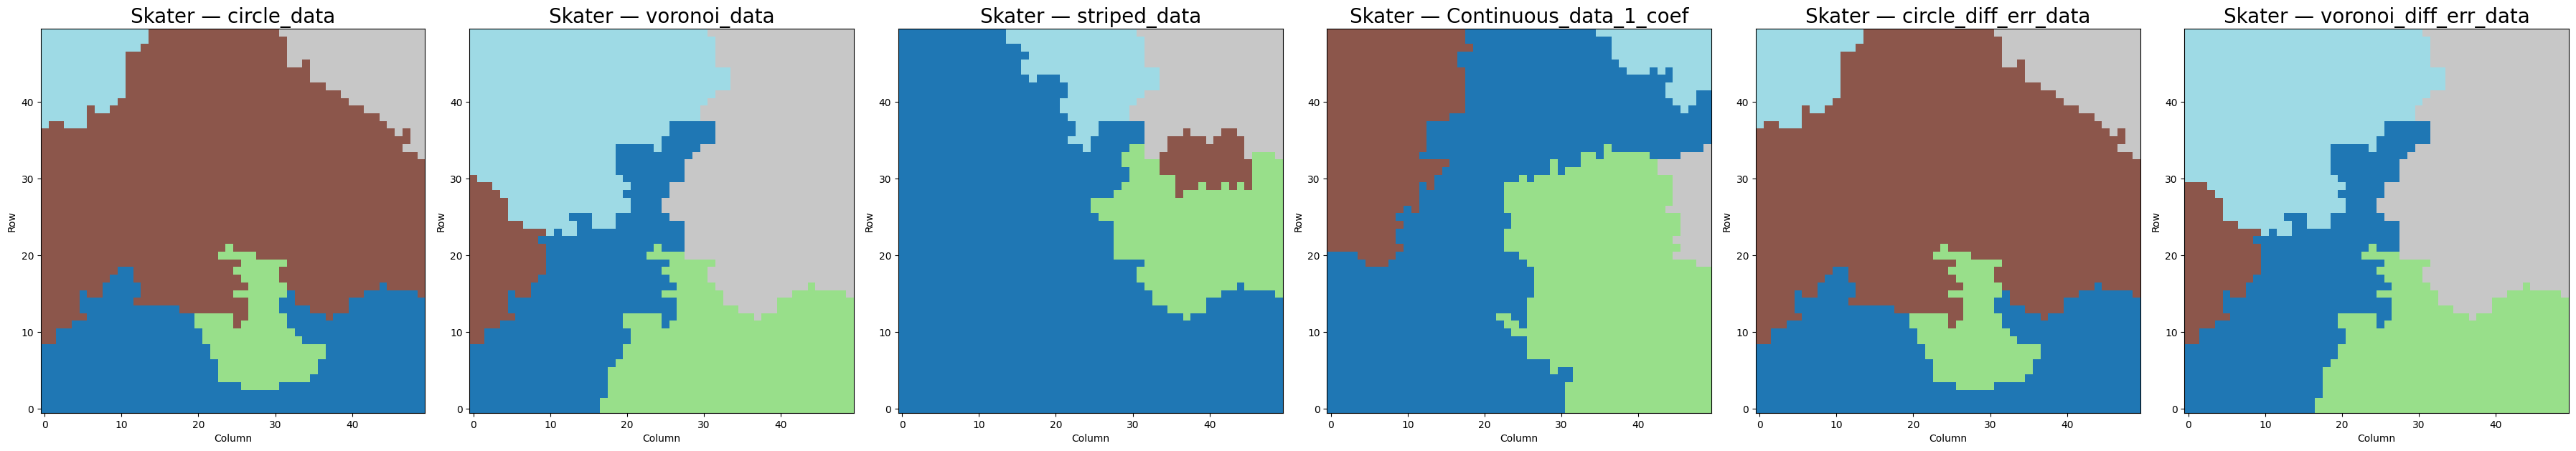

In [30]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from libpysal import weights
from Algorithm9 import kmodels, split_components, greedy_merge
from Network9 import regression_error
from GridData9 import reg_pic


data_dir   = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = ["circle_data.txt",
              "voronoi_data.txt",
              "striped_data.txt",
              "Continuous_data_1_coef.txt",
              "circle_diff_err_data.txt",
              "voronoi_diff_err_data.txt",
             "dis_con_2_coef.txt"]

grids, titles = [], []
for fname in file_names:
    path = os.path.join(data_dir, fname)
    df   = pd.read_csv(path, sep='\t')
    
    side = int(df['u'].max()) + 1
    w    = weights.lat2W(side, side).symmetrize()
    #w = ps.weights.Queen.from_dataframe(df, use_index=True)
    
    # 所有feat
    feat_cols = [c for c in df.columns if c.startswith('feat')]
    X = df[feat_cols].to_numpy()
    y = df['y'].to_numpy()
    
    X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    
    #Skater Regression
    n_regions = 5
    skater    = Skater_reg()
    res       = skater.fit(
        n_regions,
        w,
        X_std,
        {'reg': spreg.OLS, 'y': y, 'x': X},
        quorum=20            # 最小区域单元数
    )
    labels    = res._trace[-1][0]  # 0-regions-1

    grids.append(reg_pic(side, labels))
    titles.append(fname.replace('.txt', ''))

fig, axes = plt.subplots(1, len(grids), figsize=(6 * len(grids), 6), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    ax.imshow(grid, origin='lower', cmap='tab20')
    ax.set_title(f"Skater — {title}", fontsize=20)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

plt.tight_layout()
plt.show()


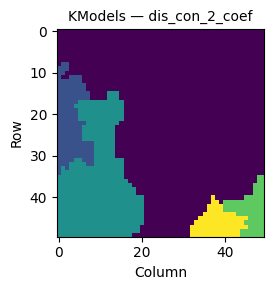

In [45]:
data_dir   = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = ["dis_con_2_coef.txt"]

grids, titles = [], []
for fname in file_names:
    path = os.path.join(data_dir, fname)
    df   = pd.read_csv(path, sep='\t')
    
    side = int(df['u'].max()) + 1
    w    = weights.lat2W(side, side).symmetrize()
    #w = ps.weights.Queen.from_dataframe(df, use_index=True)
    
    feat_cols = [c for c in df.columns if c.startswith('feat')]
    X = df[feat_cols].to_numpy()
    y = df['y'].to_numpy()
    
    X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    
    #Skater Regression
    n_regions = 5
    skater    = Skater_reg()
    res       = skater.fit(
        n_regions,
        w,
        X_std,
        {'reg': spreg.OLS, 'y': y, 'x': X},
        quorum=20            # 最小区域单元数
    )
    labels    = res._trace[-1][0]  # 0-regions-1

    grids.append(reg_pic(side, labels))
    titles.append(fname.replace('.txt', ''))

fig, axes = plt.subplots(1, len(grids), figsize=(3, 3), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    im = ax.imshow(grid, cmap='viridis')
    ax.set_title(f"KModels — {title}", fontsize=10)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

plt.tight_layout()
plt.show()

### SCR

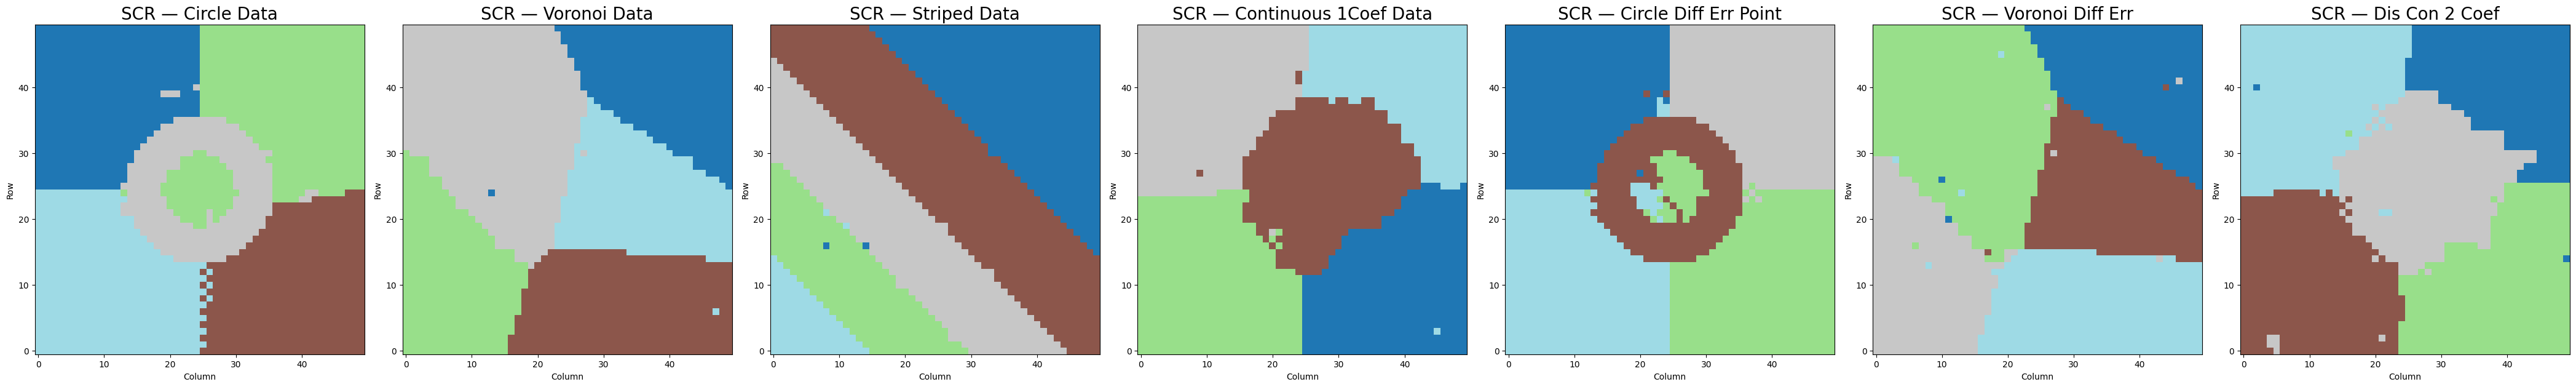

In [53]:
data_dir = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\SCR"
file_names = [
    "SCR_circle_data.txt",
    "SCR_voronoi_data.txt",
    "SCR_striped_data.txt",
    "SCR_continuous_1coef_data.txt",
    "SCR_circle_diff_err_point.txt",
    "SCR_voronoi_diff_err.txt",
    "SCR_dis_con_2_coef.txt"
]

grids = []
titles = []

for fname in file_names:
    path = os.path.join(data_dir, fname)
    df = pd.read_csv(path, sep='\t')
    size_x = len(np.unique(df['v']))
    size_y = len(np.unique(df['u']))
    
    region_array = df.sort_values(['v', 'u'])['group'].to_numpy()
    region_grid = region_array.reshape(size_y, size_x)
    
    grids.append(region_grid)
    
    title = os.path.splitext(fname)[0] \
            .replace("SCR_", "") \
            .replace("_", " ") \
            .title()
    titles.append(title)

fig, axes = plt.subplots(
    1, len(grids),
    figsize=(6 * len(grids), 6),
    squeeze=False
)

for ax, grid, title in zip(axes[0], grids, titles):
    ax.imshow(grid, origin='lower', cmap='tab20')
    ax.set_title(f"SCR — {title}", fontsize=20)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

plt.tight_layout()
plt.show()

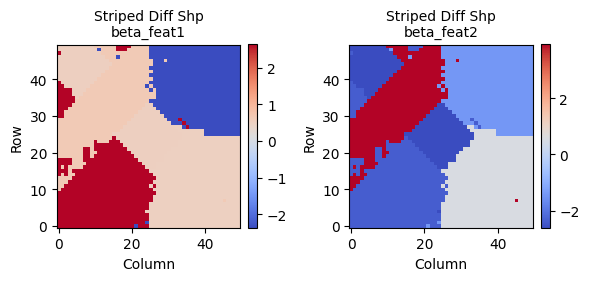

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\SCR"
file_name = "SCR_striped_diff_shp.txt"

coef_cols = ['beta_feat1', 'beta_feat2']

path = os.path.join(data_dir, file_name)
df = pd.read_csv(path, sep='\t')

size_x = len(np.unique(df['v']))
size_y = len(np.unique(df['u']))

# 按 (v,u) 排序并提取两个系数的网格
grids = []
for coef in coef_cols:
    arr = df.sort_values(['v', 'u'])[coef].to_numpy()
    grid = arr.reshape(size_y, size_x)
    grids.append(grid)


fig, axes = plt.subplots(1, 2, figsize=(6, 6))
for ax, grid, coef in zip(axes, grids, coef_cols):
    im = ax.imshow(grid, origin='lower', cmap='coolwarm')
    ax.set_title(f"{file_name[:-4].replace('SCR_', '').replace('_',' ').title()}\n{coef}", fontsize=10)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### SCC

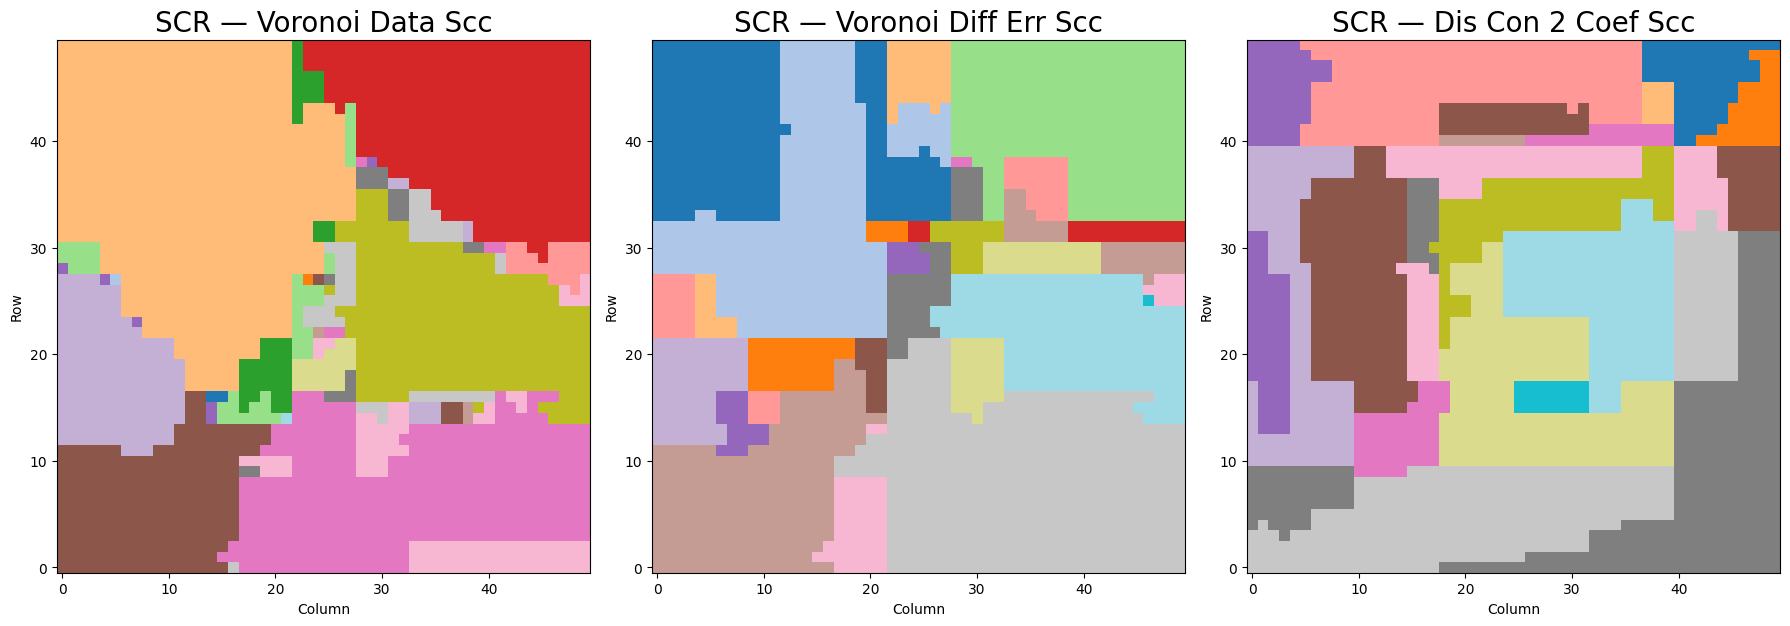

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_dir = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\SCC_matlab_2019"
file_names = [
    "voronoi_data_SCC.txt",
    "voronoi_diff_err_SCC.txt",
    "dis_con_2_coef_SCC.txt"
]

grids = []
titles = []

for fname in file_names:
    path = os.path.join(data_dir, fname)
    df = pd.read_csv(path, sep='\t')
    size_x = len(np.unique(df['v']))
    size_y = len(np.unique(df['u']))
    
    region_array = df.sort_values(['v', 'u'])['beta_feat1'].to_numpy()
    region_grid = region_array.reshape(size_y, size_x)
    
    grids.append(region_grid)
    
    title = os.path.splitext(fname)[0] \
            .replace("SCR_", "") \
            .replace("_", " ") \
            .title()
    titles.append(title)

fig, axes = plt.subplots(
    1, len(grids),
    figsize=(6 * len(grids), 6),
    squeeze=False
)

for ax, grid, title in zip(axes[0], grids, titles):
    ax.imshow(grid, origin='lower', cmap='tab20')
    ax.set_title(f"SCR — {title}", fontsize=20)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

plt.tight_layout()
plt.show()

### AZP

In [61]:
from spopt.region import AZP
from GridData9 import reg_pic

data_dir = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = [
    "circle_data.txt",
    "voronoi_data.txt",
    "striped_data.txt",
    "continuous_data_1_coef.txt"
]

grids, titles = [], []
for fname in file_names:
    df = pd.read_csv(os.path.join(data_dir, fname), sep='\t')
    
    side = int(df['u'].max()) + 1
    w    = weights.lat2W(side, side).symmetrize()
    
    attrs = [c for c in df.columns if c.startswith('feat')]
    
    n_regions = df['region'].nunique()
    
    model = AZP(df, w, attrs, n_regions)
    model.solve()
    
    labels = model.labels_
    grids.append(reg_pic(side, labels))
    titles.append(fname.replace('.txt',''))

fig, axes = plt.subplots(1, len(grids), figsize=(6 * len(grids), 6), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    ax.imshow(grid, origin='lower', cmap='tab20')
    ax.set_title(f"AZP — {title}", fontsize=20)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

### SKATER

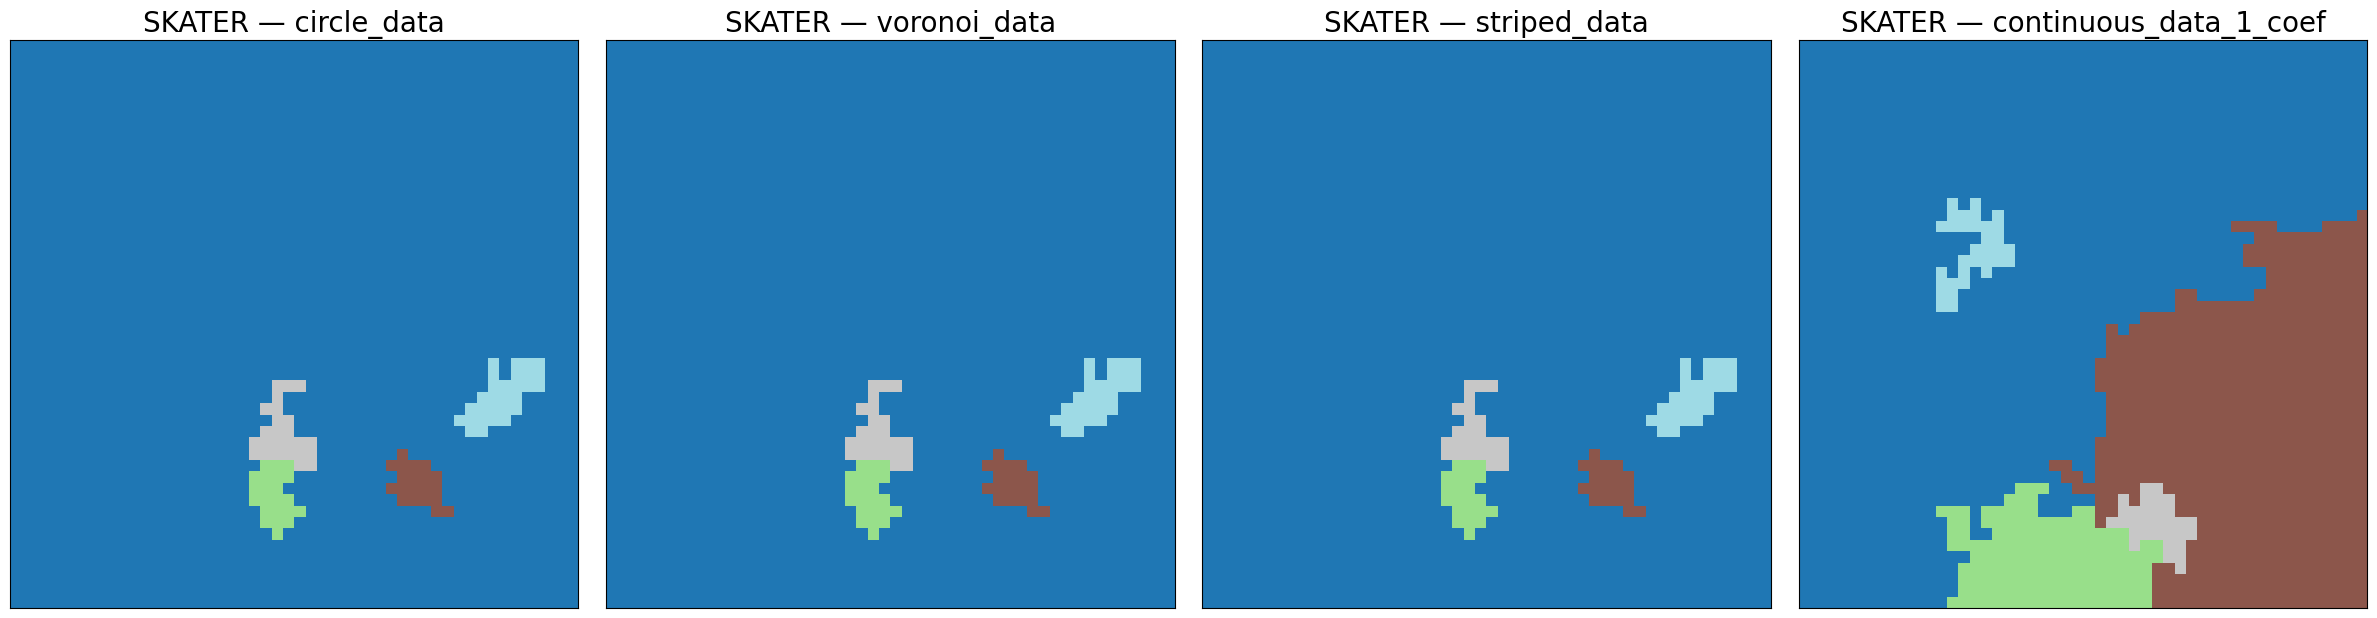

In [64]:
from spopt.region.skater import Skater       # SKATER 聚类
from GridData9 import reg_pic

data_dir   = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = [
    "circle_data.txt",
    "voronoi_data.txt",
    "striped_data.txt",
    "continuous_data_1_coef.txt"
]


grids, titles = [], []
for fname in file_names:

    df = pd.read_csv(os.path.join(data_dir, fname), sep='\t')
    
    side = int(df['u'].max()) + 1
    w    = weights.lat2W(side, side).symmetrize()
    
    attrs = [c for c in df.columns if c.startswith('feat')]
    
    n_regions = 5
    
    # 2.5 初始化并求解 SKATER
    #     参数说明：
    #       - df: GeoDataFrame 或 DataFrame，只要有 attrs 列即可
    #       - w : 空间权重矩阵
    #       - attrs: 属性列名列表，用于度量区域内同质性
    #       - n_regions: 聚类数
    #       - floor: 最小区域单元数，可以不传则无下限
    model = Skater(df, w, attrs, n_regions, floor=20)
    model.solve()

    labels = model.labels_
    grids.append(reg_pic(side, labels))
    titles.append(fname.replace('.txt',''))

fig, axes = plt.subplots(1, len(grids), figsize=(6 * len(grids), 6), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    ax.imshow(grid, origin='lower', cmap='tab20')
    ax.set_title(f"SKATER — {title}", fontsize=20)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

### MGWR

In [ ]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import MGWR

data_dir = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data"
file_names = [
    "circle_data.txt",
    "voronoi_data.txt",
    "striped_data.txt",
    "continuous_data_1_coef.txt"
]

grids, titles = [], []
for fname in file_names:
    df = pd.read_csv(os.path.join(data_dir, fname), sep='\t')
    
    coords = df[['x_coord', 'y_coord']].to_numpy()
    y      = df['y'].to_numpy().reshape((-1, 1))
    feat_cols = [c for c in df.columns if c.startswith('feat')]
    X_feat = df[feat_cols].to_numpy()
    
    X = np.hstack([np.ones((len(df), 1)), X_feat])
    
    # 带宽
    bw_selector = Sel_BW(coords, y, X, multi=True)
    bws = bw_selector.search()
    
    mgwr_model   = MGWR(coords, y, X, bws)
    mgwr_results = mgwr_model.fit()
    
    # 提取 feat1 系数（参数矩阵第 2 列）
    coef1 = mgwr_results.params[:, 1]
    
    #将 coef1 重塑为 side×side 网格
    side = int(np.sqrt(len(df)))
    grid_coef1 = coef1.reshape(side, side)
    
    grids.append(grid_coef1)
    titles.append(fname.replace('.txt', ''))

fig, axes = plt.subplots(1, len(grids), figsize=(6 * len(grids), 4), squeeze=False)
for ax, grid, title in zip(axes[0], grids, titles):
    im = ax.imshow(grid, origin='lower', cmap='viridis')
    ax.set_title(f"MGWR feat1 — {title}", fontsize=12)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()
